# Creating dataset from video

Load tracking data

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

In [89]:
source_csv_file = 'data/tracking_data.csv'
destination_csv_file = 'data/classification_dataset.csv'

In [90]:
source_csv_file = 'data/tracking_data.csv'
df = pd.read_csv(source_csv_file)
df.head()

,frame,id,x1,y1,x2,y2,xc,yc,class,wave,video
0,12,0,-5,336,396,785,195,560,palm,1,video1.mp4
1,12,1,1297,389,1554,751,1425,570,palm,1,video1.mp4
2,13,0,-5,291,391,740,193,515,palm,1,video1.mp4
3,13,1,1299,356,1556,720,1427,538,palm,1,video1.mp4
4,14,0,-5,252,385,703,190,477,palm,1,video1.mp4


`window_function` is a function that returns labeled windows for given `id` and `video` and `starting_window`. Windows is number of frames for which signal is considered. In our case we want to detect hand wave, so we will use `window_size` = 40, as our camera captures 30 frames per second, which means that wave needs to be a bit over a second long. 

In [91]:
def window_function(df, id, video, starting_window, window_size=30, skip=2):
    labeled_windows = []  # List to store labeled windows
    
    # Filter DataFrame rows for the given ID and video
    id_video_df = df[(df['id'] == id) & (df['video'] == video)]

    # Iterate over the DataFrame rows with specified skip
    for start_idx in range(0, len(id_video_df) - window_size + 1, skip):
        # Extract frames for the current window
        window_frames = id_video_df.iloc[start_idx:start_idx+window_size]
        
        # Append the window and its label to the list
        labeled_windows.append((window_frames, starting_window))
        starting_window += 1  # Increment the window number
    
    return labeled_windows

Create new dataset with `window` label, so that we have signals of the same length.

In [92]:
starting_window = 0 # will be unique accross all videos

new_df = df.copy()

# Iterate over each unique combination of ID and video name in the DataFrame
for (id, video) in df[['id', 'video']].drop_duplicates().itertuples(index=False):
    # Get labeled windows for the current ID and video name
    id_video_windows = window_function(df, id=id, video=video, skip=10, window_size=40, starting_window=starting_window)
    starting_window += len(id_video_windows)  # Update starting window for the next video

    for window, window_number in id_video_windows:
        new_df = pd.concat([new_df, window.assign(window=window_number)])


# remove rows with NaN values which were noise
new_df.dropna(inplace=True)
new_df.reset_index(drop=True, inplace=True)

# Convert 'window_num' column to integer type
new_df['window'] = new_df['window'].astype(int)

Save dataset to `data` folder.

In [93]:
# Save the new DataFrame to a CSV file
new_df.to_csv(destination_csv_file, index=False)

# Preprocessing data

loading dataset

In [94]:
dataset = pd.read_csv(destination_csv_file)
dataset.head()

,frame,id,x1,y1,x2,y2,xc,yc,class,wave,video,window
0,12,1,1297,389,1554,751,1425,570,palm,1,video1.mp4,0
1,13,1,1299,356,1556,720,1427,538,palm,1,video1.mp4,0
2,14,1,1298,327,1553,692,1425,509,palm,1,video1.mp4,0
3,15,1,1295,305,1550,673,1422,489,palm,1,video1.mp4,0
4,16,1,1293,290,1546,663,1419,476,palm,1,video1.mp4,0


In [95]:
def plot_wave(xc, yc, title):
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))
    
    # Plot xc
    axs[0].plot(range(len(xc)), xc, label='X center', color='purple')
    axs[0].set_title(title)
    axs[0].set_xlabel('Frame')
    axs[0].set_ylabel('Amplitude')
    axs[0].legend(loc='upper right')
    
    # Plot yc
    axs[1].plot(range(len(yc)), yc, label='Y center', color='green')
    axs[1].set_xlabel('Frame')
    axs[1].set_ylabel('Amplitude')
    axs[1].legend(loc='upper right')

    # Plot xc and yc
    axs[2].plot(xc, yc, label='Movement', color='red')
    axs[2].set_xlabel('X center')
    axs[2].set_ylabel('Y center')
    axs[2].legend(loc='upper right')
    axs[2].set_aspect('equal', adjustable='box')  # Set square shape
    
    plt.tight_layout()
    plt.show()

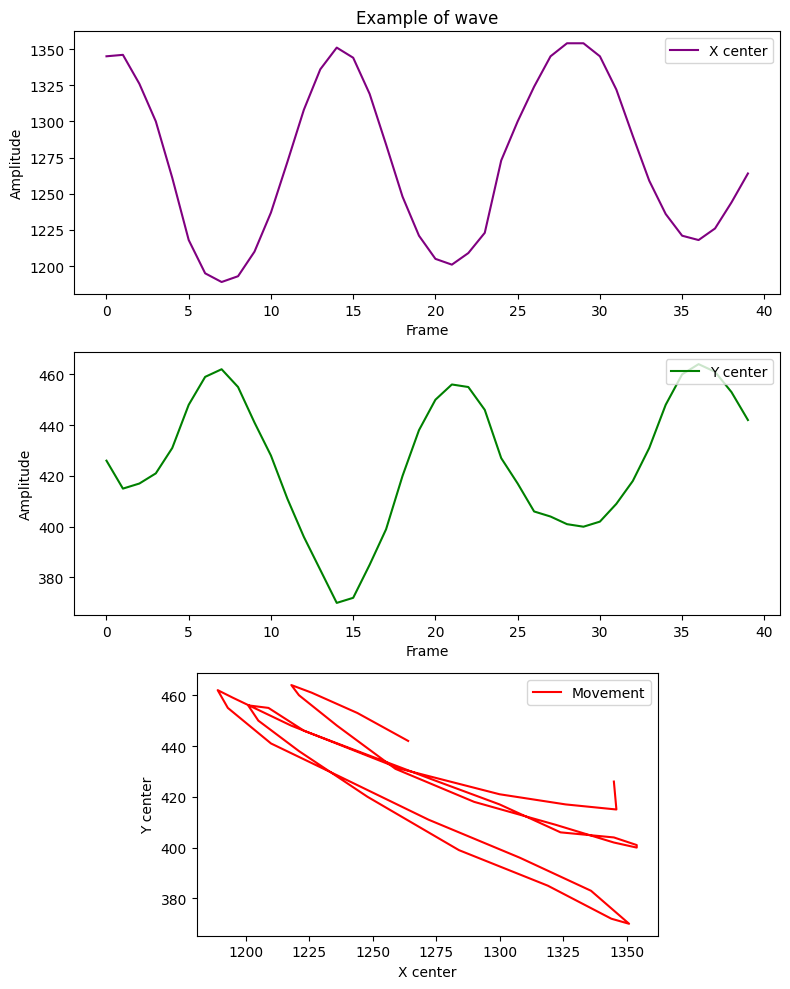

In [96]:
window = 2
xc_wave = dataset.xc[(dataset.window == window) & (dataset.wave == 1)]
yc_wave = dataset.yc[(dataset.window == window) & (dataset.wave == 1)]
plot_wave(xc_wave, yc_wave, "Example of wave")

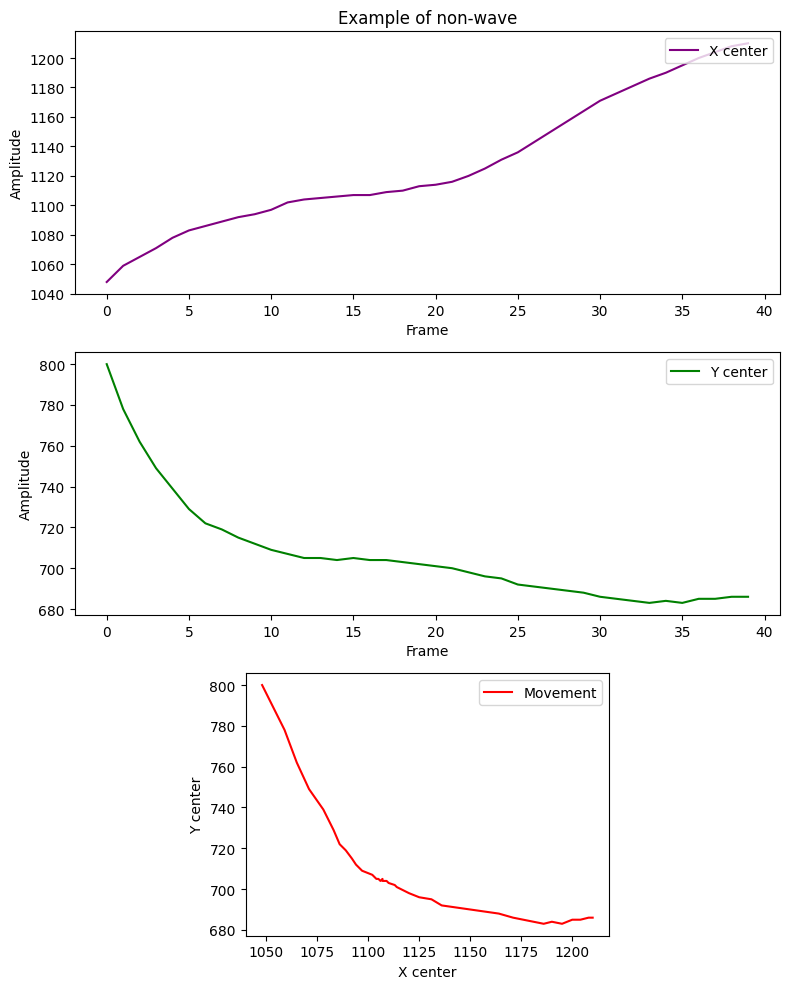

In [97]:
window = 16
xc_non_wave = dataset.xc[(dataset.window == window) & (dataset.wave == 0)]
yc_non_wave = dataset.yc[(dataset.window == window) & (dataset.wave == 0)]
plot_wave(xc_non_wave, yc_non_wave, "Example of non-wave")

In [98]:
def highpass_filter(signal, cutoff_frequency=0.1, sampling_rate=30):
    # Design a Butterworth high-pass filter
    order = 4  # Filter order
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba')

    # Apply the filter to the signal
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal

In [99]:
frame_rate = 30
width = 1920
height = 1080
cutoff_frequency = 0.1

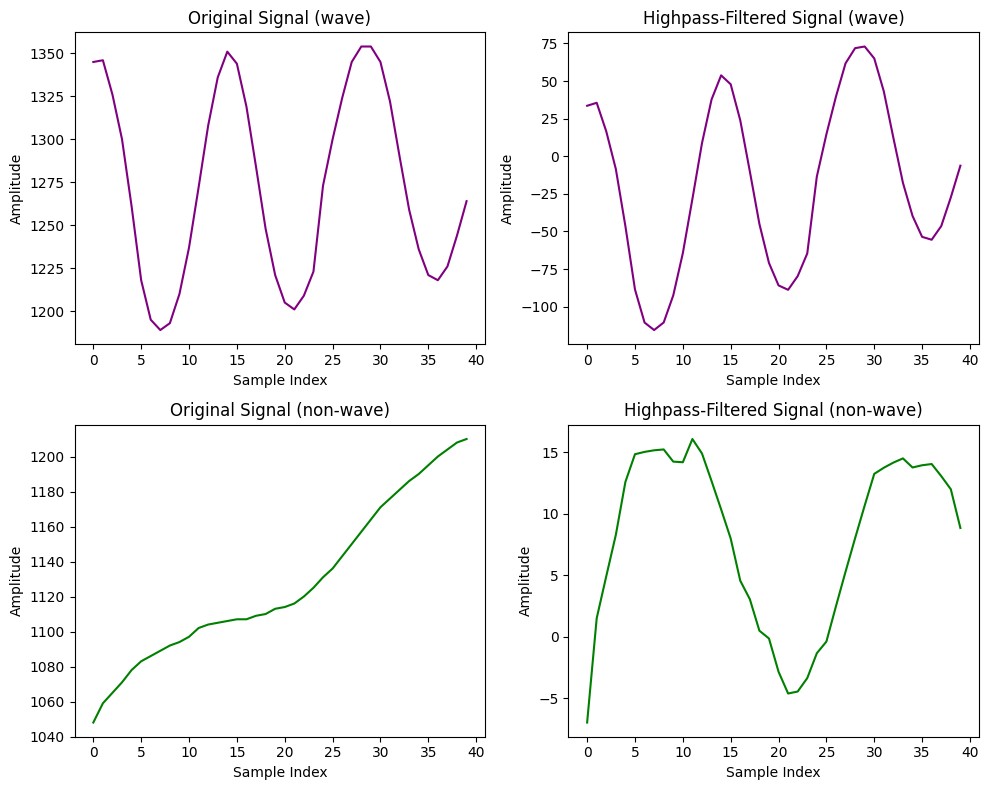

In [100]:
def filter_compare(xc_wave, xc_non_wave):
    xc_wave_filtered = highpass_filter(xc_wave, cutoff_frequency, frame_rate)
    xc_non_wave_filtered = highpass_filter(xc_non_wave, cutoff_frequency, frame_rate)

    plt.figure(figsize=(10, 8))

    # Plot xc_wave
    plt.subplot(221)
    plt.plot(range(len(xc_wave)), xc_wave, color='purple')
    plt.title('Original Signal (wave)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

    # Plot xc_wave_filtered
    plt.subplot(222)
    plt.plot(range(len(xc_wave_filtered)), xc_wave_filtered, color='purple')
    plt.title('Highpass-Filtered Signal (wave)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

    # Plot xc_non_wave
    plt.subplot(223)
    plt.plot(range(len(xc_non_wave)), xc_non_wave, color='green')
    plt.title('Original Signal (non-wave)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

    # Plot xc_non_wave_filtered
    plt.subplot(224)
    plt.plot(range(len(xc_non_wave_filtered)), xc_non_wave_filtered, color='green')
    plt.title('Highpass-Filtered Signal (non-wave)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()


filter_compare(xc_wave, xc_non_wave)

Plotting Frequency domain of the signal

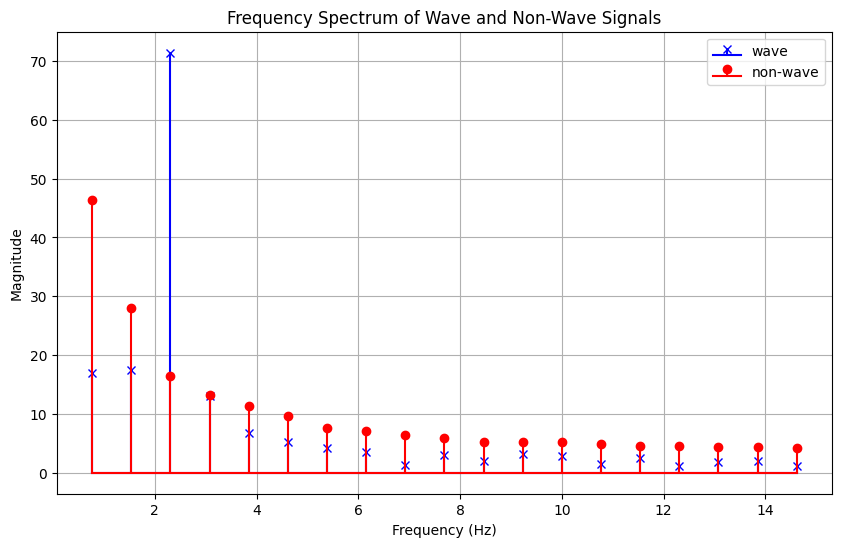

In [101]:
def plot_frequency_spectrum(xc_wave, xc_non_wave, frame_rate, title):
    N = len(xc_wave)
    f = np.linspace(0, frame_rate, N)
    X1 = np.fft.fft(xc_wave)
    X2 = np.fft.fft(xc_non_wave)
    
    plt.figure(figsize=(10, 6))
    plt.stem(f[1:N//2], 2/N * np.abs(X1[1:N//2]), markerfmt='bx', linefmt='b-', basefmt='b', label='wave')
    plt.stem(f[1:N//2], 2/N * np.abs(X2[1:N//2]), markerfmt='ro', linefmt='r-', basefmt='r', label='non-wave')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_frequency_spectrum(xc_wave, xc_non_wave, frame_rate, 'Frequency Spectrum of Wave and Non-Wave Signals')

## Feature engineering

In [102]:
def calculate_features(x_signal, y_signal, features, sampling_rate=30, cutoff_frequency = 0.1, width=1920, height=1080):
  # signal min max scaling
  x_signal = x_signal/width
  y_signal = y_signal/height

  # Amplitude-related features
  max_amplitude_x = np.max(x_signal)
  max_amplitude_y = np.max(y_signal)

  min_amplitude_x = np.min(x_signal)
  min_amplitude_y = np.min(y_signal)

  avg_amplitude_x = np.mean(x_signal)
  avg_amplitude_y = np.mean(y_signal)

  rms_amplitude_x = np.sqrt(np.mean(x_signal**2))
  rms_amplitude_y = np.sqrt(np.mean(y_signal**2))

  # Temporal features
  rise_time_x = 0.1 * (np.argmax(x_signal > 0.1 * max_amplitude_x) - np.argmax(x_signal > 0.9 * max_amplitude_x)) / sampling_rate
  rise_time_y = 0.1 * (np.argmax(y_signal > 0.1 * max_amplitude_y) - np.argmax(y_signal > 0.9 * max_amplitude_y)) / sampling_rate

  fall_time_x = 0.1 * (np.argmax(x_signal > 0.9 * max_amplitude_x) - np.argmax(x_signal > 0.1 * max_amplitude_x)) / sampling_rate
  fall_time_y = 0.1 * (np.argmax(y_signal > 0.9 * max_amplitude_y) - np.argmax(y_signal > 0.1 * max_amplitude_y)) / sampling_rate
  
  peak_to_peak_time_x = (np.argmax(x_signal > 0.9 * max_amplitude_x) - np.argmax(x_signal > 0.1 * max_amplitude_x)) / sampling_rate
  peak_to_peak_time_y = (np.argmax(y_signal > 0.9 * max_amplitude_y) - np.argmax(y_signal > 0.1 * max_amplitude_y)) / sampling_rate

  # Nonlinear features
  x_signal_kurtosis = kurtosis(x_signal)
  y_signal_kurtosis = kurtosis(y_signal)

  x_signal_skewness = skew(x_signal)
  y_signal_skewness = skew(y_signal)

  # Zero-crossing features with filtered signal
  filtered_x_signal = highpass_filter(x_signal, cutoff_frequency=cutoff_frequency, sampling_rate=sampling_rate)
  filtered_y_signal = highpass_filter(y_signal, cutoff_frequency=cutoff_frequency, sampling_rate=sampling_rate)
  
  zero_crossing_rate_x = np.sum(np.diff(np.sign(filtered_x_signal)) != 0) / (2 * len(filtered_x_signal) / sampling_rate)
  zero_crossing_rate_y = np.sum(np.diff(np.sign(filtered_y_signal)) != 0) / (2 * len(filtered_y_signal) / sampling_rate)

  # FFT
  fft_x_signal = fft(x_signal.values)
  fft_y_signal = fft(y_signal.values)

  fft3_x = np.abs(fft_x_signal[2])
  fft3_y = np.abs(fft_y_signal[2])

  # Peaks
  peaks_x, _ = find_peaks(x_signal)
  peaks_y, _ = find_peaks(y_signal)

  num_peaks_x = len(peaks_x)
  num_peaks_y = len(peaks_y)

  features.append({
      'x_max_amplitude': max_amplitude_x,
      'y_max_amplitude': max_amplitude_y,
      'x_min_amplitude': min_amplitude_x,
      'y_min_amplitude': min_amplitude_y,
      'x_avg_amplitude': avg_amplitude_x,
      'y_avg_amplitude': avg_amplitude_y,
      'x_rms_amplitude': rms_amplitude_x,
      'y_rms_amplitude': rms_amplitude_y,
      'x_rise_time': rise_time_x,
      'y_rise_time': rise_time_y,
      'x_fall_time': fall_time_x,
      'y_fall_time': fall_time_y,
      'x_peak_to_peak_time': peak_to_peak_time_x,
      'y_peak_to_peak_time': peak_to_peak_time_y,
      'x_signal_kurtosis': x_signal_kurtosis,
      'y_signal_kurtosis': y_signal_kurtosis,
      'x_signal_skewness': x_signal_skewness,
      'y_signal_skewness': y_signal_skewness,
      'x_zero_crossing_rate': zero_crossing_rate_x,
      'y_zero_crossing_rate': zero_crossing_rate_y,
      'x_fft3': fft3_x,
      'y_fft3': fft3_y,
      'x_num_peaks': num_peaks_x,
      'y_num_peaks': num_peaks_y
  })

In [103]:
wave_features = []
non_wave_features = []

for window_id, window in dataset[dataset.wave == 1].groupby('window'):
    x_signal = window.xc
    y_signal = window.yc
    calculate_features(x_signal=x_signal, y_signal=y_signal, features=wave_features)

for window_id, window in dataset[dataset.wave == 0].groupby('window'):
    x_signal = window.xc
    y_signal = window.yc
    calculate_features(x_signal=x_signal, y_signal=y_signal, features=non_wave_features)

print(f"No. of wave signals: {len(wave_features)} having {len(wave_features[0])} features")
print(f"No. of non-wave signals: {len(non_wave_features)} having {len(non_wave_features[0])} features")


No. of wave signals: 16 having 24 features
No. of non-wave signals: 1 having 24 features


In [104]:
wave_features[0]

{'x_max_amplitude': 0.7432291666666667,
 'y_max_amplitude': 0.5277777777777778,
 'x_min_amplitude': 0.6192708333333333,
 'y_min_amplitude': 0.3425925925925926,
 'x_avg_amplitude': 0.6868489583333333,
 'y_avg_amplitude': 0.4128703703703704,
 'x_rms_amplitude': 0.6878041270188027,
 'y_rms_amplitude': 0.414569723394697,
 'x_rise_time': 0.0,
 'y_rise_time': 0.0,
 'x_fall_time': 0.0,
 'y_fall_time': 0.0,
 'x_peak_to_peak_time': 0.0,
 'y_peak_to_peak_time': 0.0,
 'x_signal_kurtosis': -0.8801966865567001,
 'y_signal_kurtosis': 1.112769758608648,
 'x_signal_skewness': -0.18327898474266469,
 'y_signal_skewness': 0.5779086692261504,
 'x_zero_crossing_rate': 1.875,
 'y_zero_crossing_rate': 0.375,
 'x_fft3': 0.2450098221559329,
 'y_fft3': 0.39234274118527085,
 'x_num_peaks': 3,
 'y_num_peaks': 3}

In [105]:
non_wave_features[0]

{'x_max_amplitude': 0.6302083333333334,
 'y_max_amplitude': 0.7407407407407407,
 'x_min_amplitude': 0.5458333333333333,
 'y_min_amplitude': 0.6324074074074074,
 'x_avg_amplitude': 0.587265625,
 'y_avg_amplitude': 0.6541666666666667,
 'x_rms_amplitude': 0.5877257780370628,
 'y_rms_amplitude': 0.654615223268585,
 'x_rise_time': -0.02666666666666667,
 'y_rise_time': 0.0,
 'x_fall_time': 0.02666666666666667,
 'y_fall_time': 0.0,
 'x_peak_to_peak_time': 0.26666666666666666,
 'y_peak_to_peak_time': 0.0,
 'x_signal_kurtosis': -0.9491316030338313,
 'y_signal_kurtosis': 3.371072740628942,
 'x_signal_skewness': 0.36724971158314434,
 'y_signal_skewness': 1.8857203048560292,
 'x_zero_crossing_rate': 1.125,
 'y_zero_crossing_rate': 0.375,
 'x_fft3': 0.29088742209228985,
 'y_fft3': 0.3227736253418336,
 'x_num_peaks': 0,
 'y_num_peaks': 2}

Comparison of distribution of the features between wave and non-wave signals

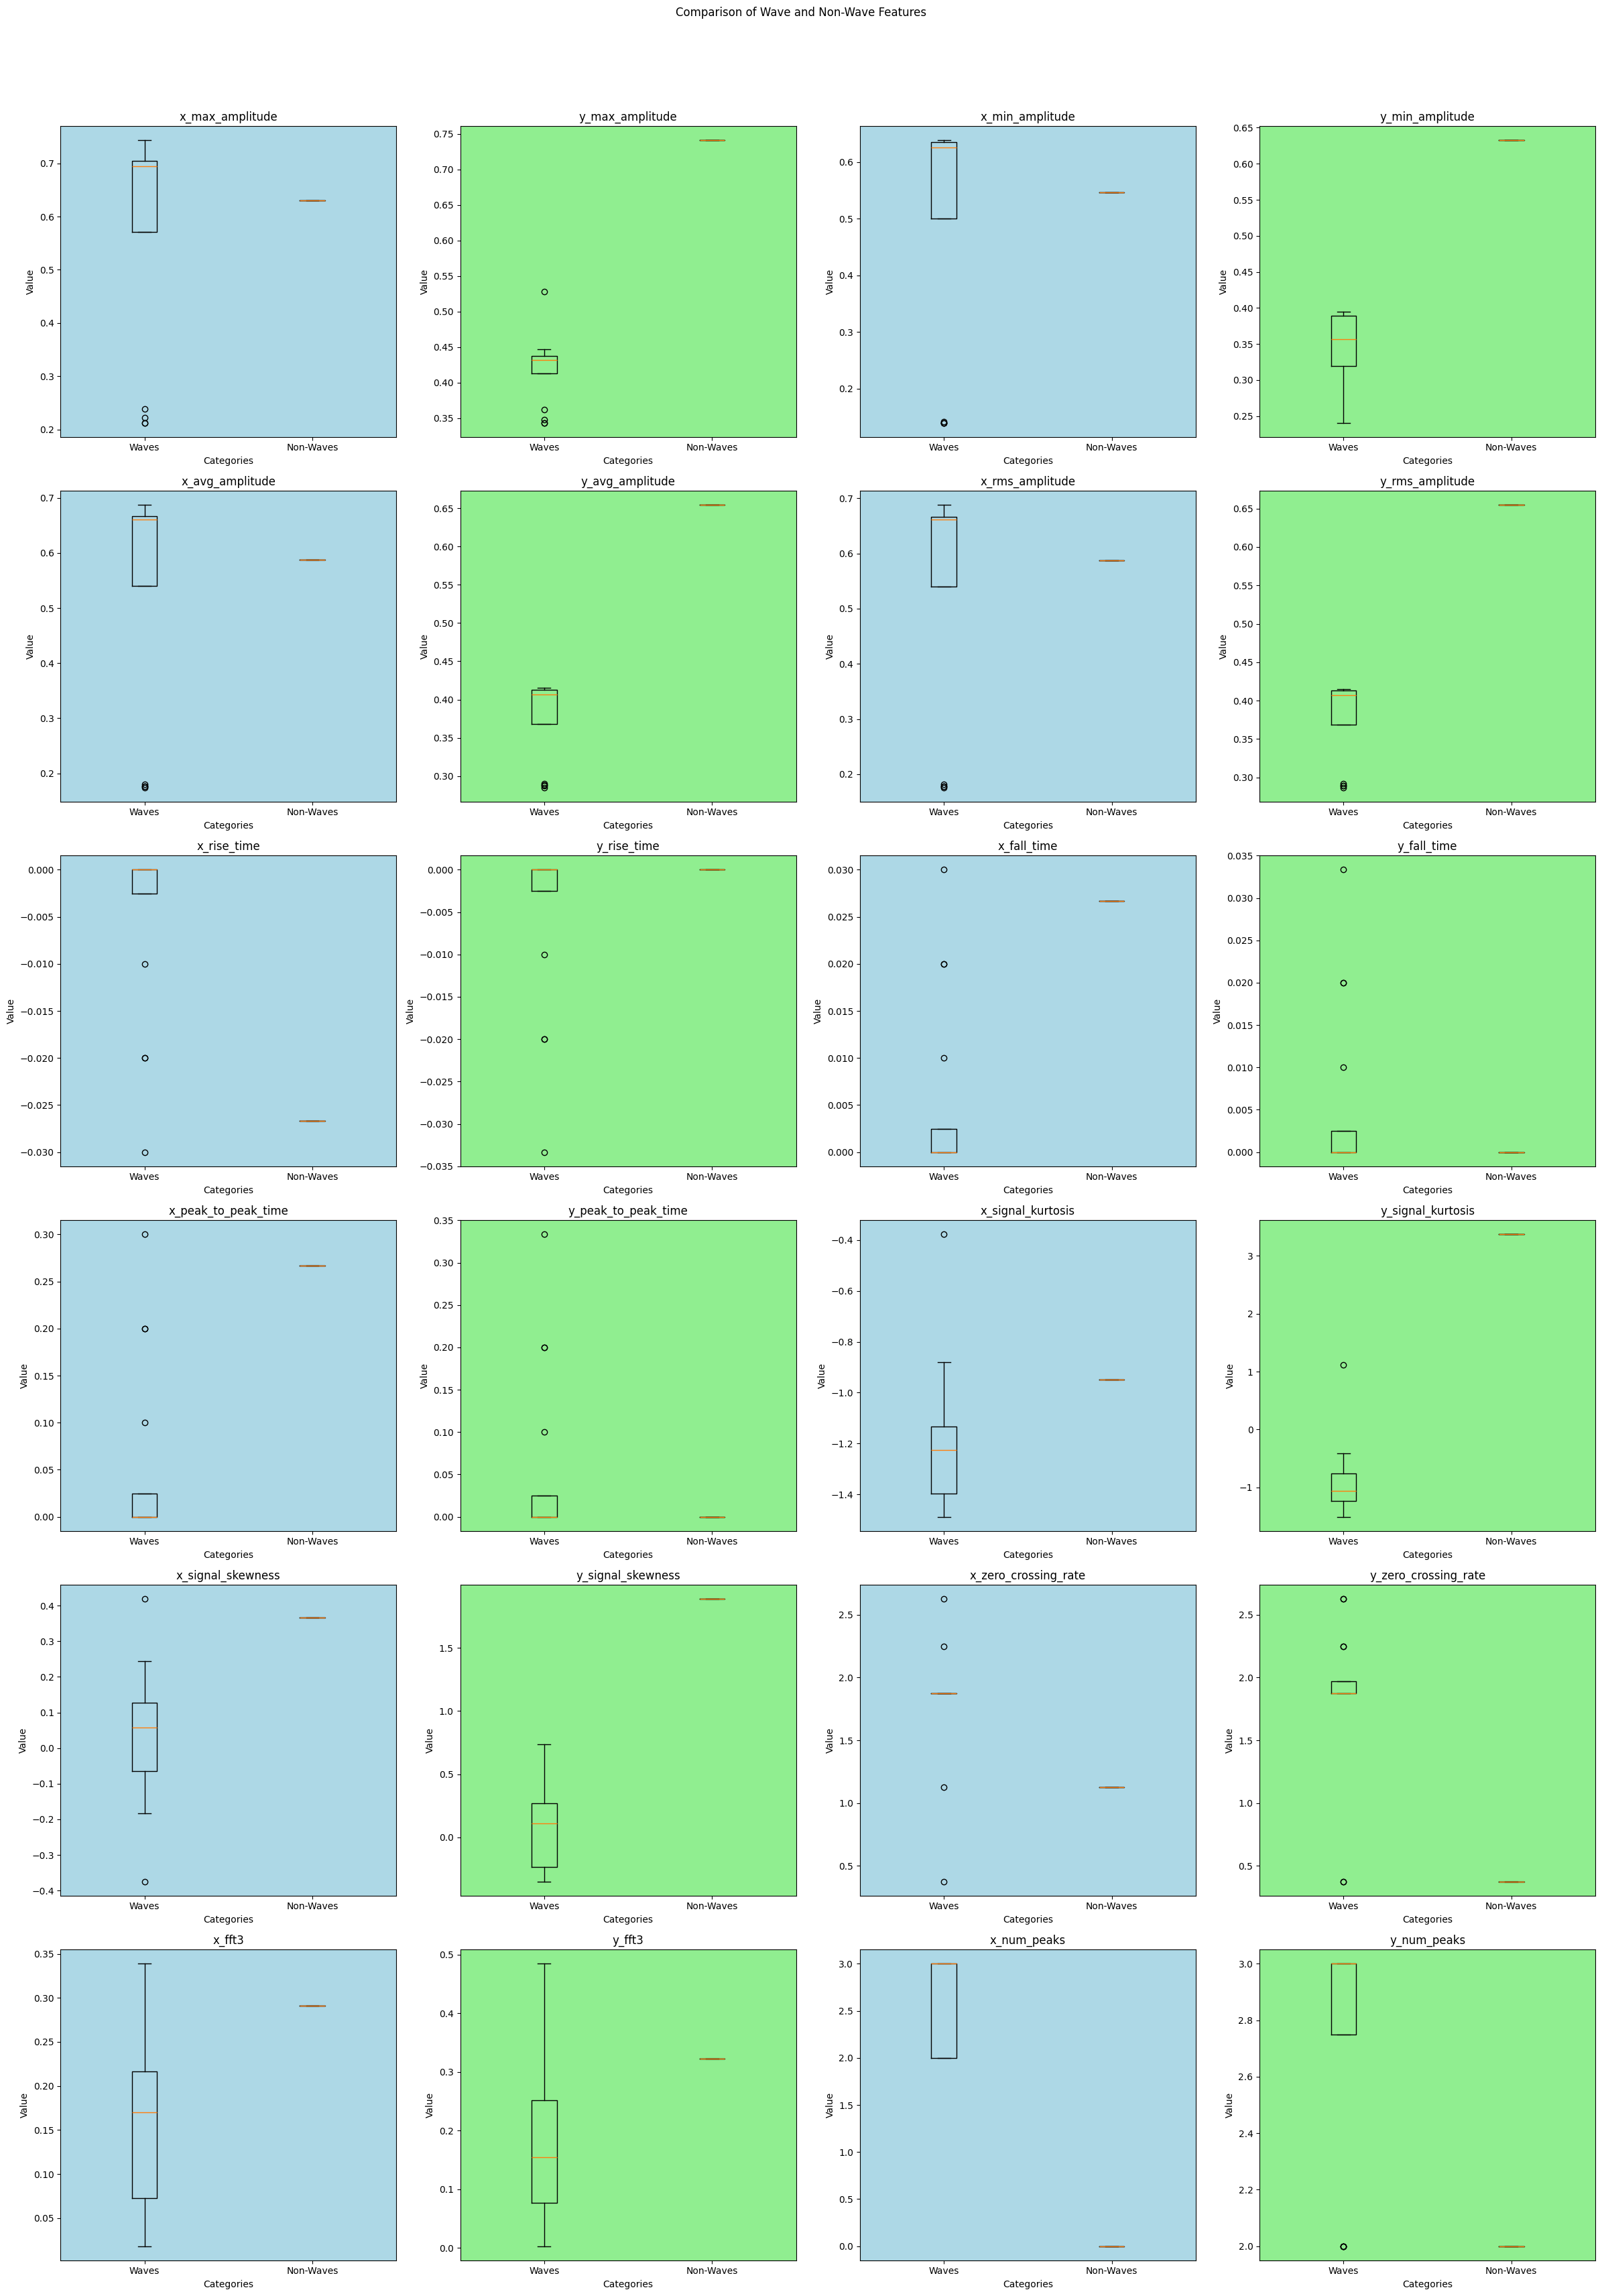

In [106]:
def plot_all_features(wave_features, non_wave_features, title):
    # Initialize a dictionary to store feature lists
    feature_values = {key: {'waves': [], 'non_waves': []} for key in wave_features[0].keys()}
    
    # Extract feature values for wave and non-wave samples
    for feature in feature_values.keys():
        wave_values = [signal[feature] for signal in wave_features]
        non_wave_values = [signal[feature] for signal in non_wave_features]
        feature_values[feature]['waves'] = wave_values
        feature_values[feature]['non_waves'] = non_wave_values

    # Calculate the number of rows and columns for subplots
    num_features = len(feature_values)
    num_cols = 4  # Number of columns per row
    num_rows = (num_features + num_cols - 1) // num_cols  # Round up division

    # Plot comparison for each feature
    plt.figure(figsize=(24, 6*num_rows))
    for i, (feature, values) in enumerate(feature_values.items()):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        ax.boxplot([values['waves'], values['non_waves']], labels=['Waves', 'Non-Waves'])
        plt.title(feature)
        plt.ylabel('Value')
        plt.xlabel('Categories')

        # Set background color for even subplots
        if i % 2 == 1:
            ax.set_facecolor('lightgreen')
        else:
            ax.set_facecolor('lightblue')

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate titles
    plt.show()

# Usage example
plot_all_features(wave_features, non_wave_features, 'Comparison of Wave and Non-Wave Features')


## Splitting data into train and test set

In [107]:
trainset = dataset[(dataset.video == 'wave_loc_1_train.mp4') | (dataset.video == 'wave_loc_2_train.mp4') | (dataset.video == 'non_wave_loc_1_train.mp4') | (dataset.video == 'non_wave_loc_2_train.mp4')]
testset = dataset[(dataset.video == 'wave_loc_3_test.mp4') | (dataset.video == 'wave_loc_3_test.mp4')]

In [108]:
wave_train_features = []
non_wave_train_features = []
wave_test_features = []
non_wave_test_features = []

for window_id, window in trainset[trainset.wave == 1].groupby('window'):
    x_signal = window.xc
    y_signal = window.yc
    calculate_features(x_signal,y_signal, wave_train_features)

for window_id, window in trainset[trainset.wave == 0].groupby('window'):
    x_signal = window.xc
    y_signal = window.yc
    calculate_features(x_signal, y_signal, non_wave_train_features)

for window_id, window in testset[testset.wave == 1].groupby('window'):
    x_signal = window.xc
    y_signal = window.yc
    calculate_features(x_signal, y_signal, wave_test_features)

for window_id, window in testset[testset.wave == 0].groupby('window'):
    x_signal = window.xc
    y_signal = window.yc
    calculate_features(x_signal, y_signal, non_wave_test_features)

print(f"No. of wave signals: {len(wave_features)} having {len(wave_features[0])} features in training set")
print(f"No. of non-wave signals: {len(non_wave_features)} having {len(non_wave_features[0])} features in training set")
print(f"No. of wave signals: {len(wave_test_features)} having {len(wave_test_features[0])} features in testing set")
print(f"No. of non-wave signals: {len(non_wave_test_features)} having {len(non_wave_test_features[0])} features in testing set")

No. of wave signals: 16 having 24 features in training set
No. of non-wave signals: 1 having 24 features in training set


IndexError: list index out of range

In [ ]:
# TODO: remove

wave_train_features = []
non_wave_train_features = []
wave_test_features = []
non_wave_test_features = []

for window_id, window in dataset[dataset.wave == 1].groupby('window'):
    x_signal = window.xc
    y_signal = window.yc
    calculate_features(x_signal,y_signal, wave_train_features)

for window_id, window in dataset[dataset.wave == 0].groupby('window'):
    x_signal = window.xc
    y_signal = window.yc
    calculate_features(x_signal, y_signal, non_wave_train_features)

for window_id, window in dataset[dataset.wave == 1].groupby('window'):
    x_signal = window.xc
    y_signal = window.yc
    calculate_features(x_signal, y_signal, wave_test_features)

for window_id, window in dataset[dataset.wave == 0].groupby('window'):
    x_signal = window.xc
    y_signal = window.yc
    calculate_features(x_signal, y_signal, non_wave_test_features)

print(f"No. of wave signals: {len(wave_features)} having {len(wave_features[0])} features in training set")
print(f"No. of non-wave signals: {len(non_wave_features)} having {len(non_wave_features[0])} features in training set")
print(f"No. of wave signals: {len(wave_test_features)} having {len(wave_test_features[0])} features in testing set")
print(f"No. of non-wave signals: {len(non_wave_test_features)} having {len(non_wave_test_features[0])} features in testing set")

No. of wave signals: 16 having 24 features in training set
No. of non-wave signals: 1 having 24 features in training set
No. of wave signals: 16 having 24 features in testing set
No. of non-wave signals: 1 having 24 features in testing set


In [ ]:
x_train, x_test, y_train, y_test = [], [], [], []

for wave in wave_train_features:
    x_train.append(list(wave.values()))
    y_train.append(1)

for non_wave in non_wave_train_features:
    x_train.append(list(non_wave.values()))
    y_train.append(0)

for wave in wave_test_features:
    x_test.append(list(wave.values()))
    y_test.append(1)

for non_wave in non_wave_test_features:
    x_test.append(list(non_wave.values()))
    y_test.append(0)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"Training set shape: {x_train.shape}, Testing set shape: {x_test.shape}")

Training set shape: (17, 24), Testing set shape: (17, 24)


# Training classifier

In [ ]:
model = RandomForestClassifier(n_estimators=3, random_state=42)
model.fit(x_train, y_train)

test_accuracy = model.score(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 1.0


In [ ]:
def get_feature_importances(forest, feature_names):
    # Get feature importances from the trained model
    importances = forest.feature_importances_
    feature_importances = [(feature, importance) for feature, importance in zip(feature_names, importances)]
    feature_importances.sort(key=lambda x: x[1], reverse=True)  # Sort by importance
    return feature_importances

def plot_feature_importances(feature_importances, title):
    # Plot feature importances
    features, importances = zip(*feature_importances)
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(features)), importances, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importance')
    plt.title(title)
    plt.show()

['x_max_amplitude', 'y_max_amplitude', 'x_min_amplitude', 'y_min_amplitude', 'x_avg_amplitude', 'y_avg_amplitude', 'x_rms_amplitude', 'y_rms_amplitude', 'x_rise_time', 'y_rise_time', 'x_fall_time', 'y_fall_time', 'x_peak_to_peak_time', 'y_peak_to_peak_time', 'x_signal_kurtosis', 'y_signal_kurtosis', 'x_signal_skewness', 'y_signal_skewness', 'x_zero_crossing_rate', 'y_zero_crossing_rate', 'x_fft3', 'y_fft3', 'x_num_peaks', 'y_num_peaks']


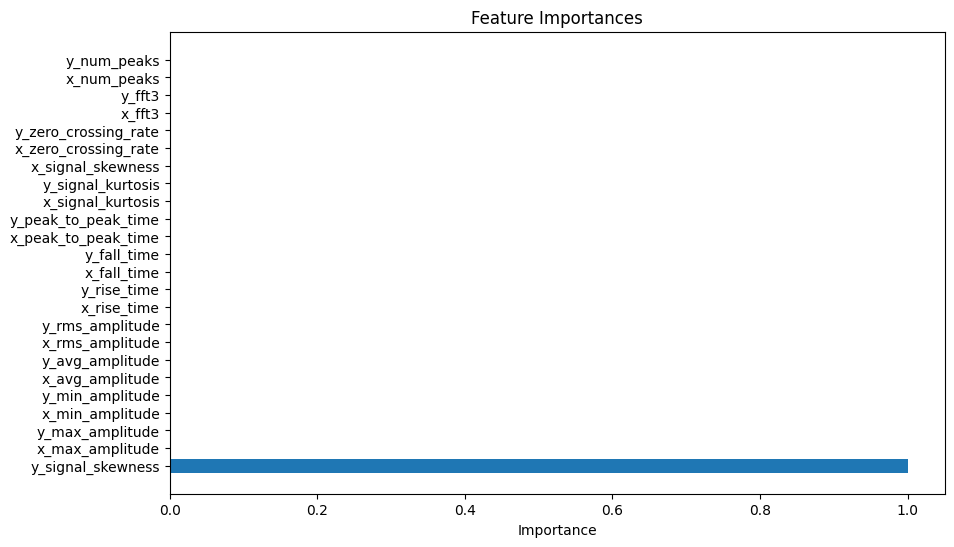

In [ ]:
feature_importances = get_feature_importances(model, list(wave_train_features[0].keys()))
plot_feature_importances(feature_importances, 'Feature Importances')

saving the model

In [ ]:
filename = 'models/classifier/wave_classifier.pkl' 
dump(model, filename)

# classifier = load(filename)

['models/classifier/wave_classifier.pkl']